<a href="https://colab.research.google.com/github/fdolisy/NLP_portfolio/blob/main/TextClassification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data

In [ ]:
#imports
import re
import nltk
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from gensim.models.word2vec import Word2Vec

from keras.layers import Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPool1D, MaxPool2D, GlobalMaxPool1D, Embedding, Activation
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, models
from tensorflow.keras import preprocessing as pp

   is_depression                                               text
0              1  we understand that most people who reply immed...
1              1  welcome to r depression s check in post a plac...
2              1  anyone else instead of sleeping more when depr...
3              1  i ve kind of stuffed around a lot in my life d...
4              1  sleep is my greatest and most comforting escap...


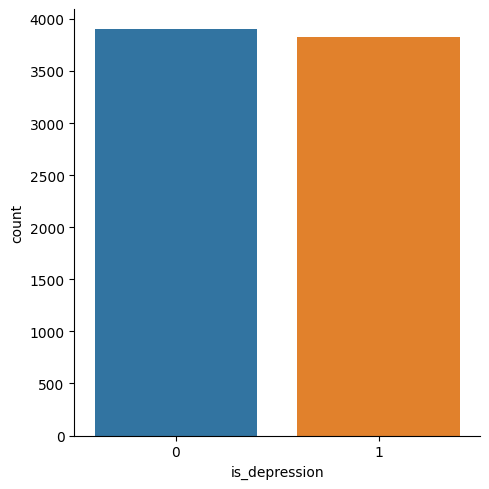

In [ ]:
# read in dataset
df = pd.read_csv('test.csv',encoding='latin-1')
df = df[['is_depression', 'clean_text']]
df.rename(columns = {"clean_text": "text"}, inplace = True)
df = df[pd.notnull(df['text'])]

print(df.head())
sb.catplot(x="is_depression", kind="count", data=df)


**Dataset Explanation**

This dataset from [kaggle](https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned) is composed from scraping subreddit comments and classifying the text as either indicating a person is depressed or not based off of the comment. Thus, the model's accuracy is dependent on whether it can determine if a message would be from a "depressed" person or not. It is composed of two columns - clean_text and is_depression. Clean_text contains the data and is_depression is a lable with 0 indicating not depressed and 1 indicated depressed.

Preprocess my data and split into training and testing set -

In [ ]:
def preprocess_text(sen: str):
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence.lower()
# preprocess text data

df['text'] = df['text'].apply(preprocess_text)
# 18774 is found upon tweaking, later found by using the 
# word2vec model that returned 18773 as the vocab size
token = Tokenizer(18774)
token.fit_on_texts(df['text'])
text = token.texts_to_sequences(df["text"])
text = pp.sequence.pad_sequences(text, 700)

le = preprocessing.LabelEncoder()
y = le.fit_transform(df['is_depression'])
y = to_categorical(y)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(np.array(text),y, test_size=0.2, stratify=y)

# Sequential Model

In [ ]:
# build and train the sequential model
seq_model = models.Sequential()
seq_model.add(tf.keras.layers.Dense(units = 110,activation = 'relu'))
seq_model.add(tf.keras.layers.Dense(units = 110,activation = 'relu'))
seq_model.add(tf.keras.layers.Dense(units = 2,activation = 'sigmoid'))
seq_model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'])
history = seq_model.fit(X_train,y_train,batch_size = 32, epochs = 100, validation_split=0.2)

Epoch 1/100
155/155 [==============================] - 7s 13ms/step - loss: 27.0845 - accuracy: 0.8181 - val_loss: 15.9651 - val_accuracy: 0.8472
Epoch 2/100
155/155 [==============================] - 1s 7ms/step - loss: 11.4713 - accuracy: 0.8466 - val_loss: 11.1596 - val_accuracy: 0.8513
Epoch 3/100
155/155 [==============================] - 1s 7ms/step - loss: 8.0383 - accuracy: 0.8557 - val_loss: 10.9195 - val_accuracy: 0.8496
Epoch 4/100
155/155 [==============================] - 1s 7ms/step - loss: 6.0849 - accuracy: 0.8646 - val_loss: 10.7683 - val_accuracy: 0.8601
Epoch 5/100
155/155 [==============================] - 1s 6ms/step - loss: 5.0701 - accuracy: 0.8648 - val_loss: 7.6783 - val_accuracy: 0.8375
Epoch 6/100
155/155 [==============================] - 1s 4ms/step - loss: 3.7247 - accuracy: 0.8741 - val_loss: 7.3792 - val_accuracy: 0.8529
Epoch 7/100
155/155 [==============================] - 1s 4ms/step - loss: 3.1051 - accuracy: 0.8761 - val_loss: 6.2477 - val_accuracy:

In [ ]:
# Test and display accuracy
pred = seq_model.predict(X_test)
print(X_test.shape)
pred_labels = np.where(pred >= 0.5, 1, 0)
print(classification_report(y_test, pred_labels))
print(f"accuracy - {accuracy_score(y_test,pred_labels)}")

49/49 [==============================] - 0s 2ms/step
(1547, 700)
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       780
           1       0.90      0.81      0.85       767

   micro avg       0.86      0.86      0.86      1547
   macro avg       0.86      0.86      0.86      1547
weighted avg       0.86      0.86      0.86      1547
 samples avg       0.86      0.86      0.86      1547

accuracy - 0.8584356819650937


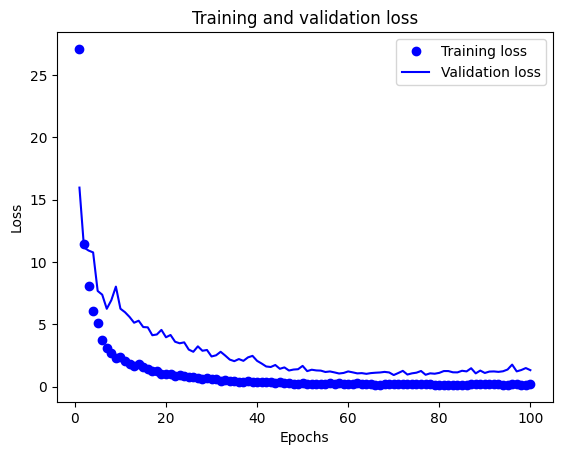

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Simple RNN - No embedding

In [ ]:
rnn_model = models.Sequential()
rnn_model.add(layers.Embedding(18848, 32))
rnn_model.add(layers.SimpleRNN(32))
rnn_model.add(layers.Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = rnn_model.fit(X_train,
                    y_train[:,0],
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
39/39 [==============================] - 14s 292ms/step - loss: 0.6664 - accuracy: 0.6155 - val_loss: 0.6663 - val_accuracy: 0.5384
Epoch 2/10
39/39 [==============================] - 10s 257ms/step - loss: 0.6499 - accuracy: 0.6325 - val_loss: 0.6920 - val_accuracy: 0.4947
Epoch 3/10
39/39 [==============================] - 10s 250ms/step - loss: 0.5318 - accuracy: 0.7898 - val_loss: 0.4029 - val_accuracy: 0.8989
Epoch 4/10
39/39 [==============================] - 9s 228ms/step - loss: 0.2996 - accuracy: 0.9088 - val_loss: 0.2495 - val_accuracy: 0.9159
Epoch 5/10
39/39 [==============================] - 10s 260ms/step - loss: 0.3290 - accuracy: 0.8433 - val_loss: 0.7389 - val_accuracy: 0.5303
Epoch 6/10
39/39 [==============================] - 10s 269ms/step - loss: 0.2881 - accuracy: 0.8961 - val_loss: 0.1881 - val_accuracy: 0.9515
Epoch 7/10
39/39 [==============================] - 10s 259ms/step - loss: 0.1138 - accuracy: 0.9739 - val_loss: 0.1413 - val_accuracy: 0.9588


In [ ]:
pred = rnn_model.predict(X_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test[:,0], pred))

49/49 [==============================] - 2s 36ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       767
         1.0       0.95      0.98      0.97       780

    accuracy                           0.97      1547
   macro avg       0.97      0.96      0.97      1547
weighted avg       0.97      0.97      0.97      1547



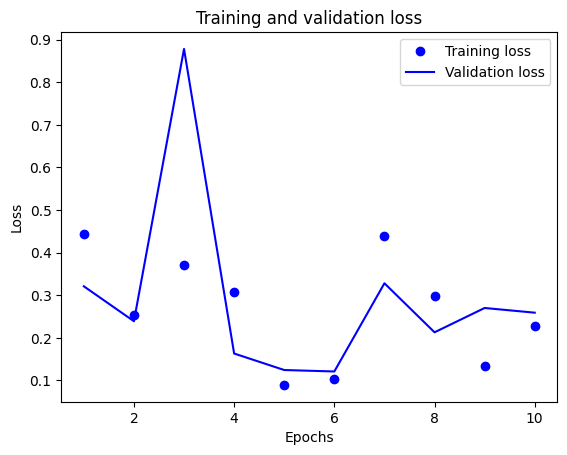

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# CNN - With Basic embedding

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Embedding(18848, 128, input_length=700)) 
cnn_model.add(layers.Conv1D(32, 5, activation='relu')) 
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling1D(5)) 
cnn_model.add(layers.Conv1D(64, 5, activation='relu')) 
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.GlobalMaxPooling1D())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(1, activation='sigmoid'))
cnn_model.add(layers.Dense(2, activation='softmax'))
cnn_model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')

In [ ]:
history = cnn_model.fit(X_train, y_train, batch_size=16, epochs=3, validation_data=(X_test,y_test))

387/387 [==============================] - 55s 136ms/step - loss: 0.6860 - acc: 0.6276 - val_loss: 0.6532 - val_acc: 0.7679
Epoch 2/3
387/387 [==============================] - 46s 118ms/step - loss: 0.5883 - acc: 0.9470 - val_loss: 0.5521 - val_acc: 0.9295
Epoch 3/3
387/387 [==============================] - 45s 117ms/step - loss: 0.5036 - acc: 0.9618 - val_loss: 0.4816 - val_acc: 0.9496


In [ ]:
pred = cnn_model.predict(X_test)
pred_labels = np.where(pred >= 0.5, 1, 0)
print(classification_report(y_test, pred_labels))
print(f"accuracy - {accuracy_score(y_test,pred_labels)}")

49/49 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       780
           1       0.98      0.92      0.95       767

   micro avg       0.95      0.95      0.95      1547
   macro avg       0.95      0.95      0.95      1547
weighted avg       0.95      0.95      0.95      1547
 samples avg       0.95      0.95      0.95      1547

accuracy - 0.9495798319327731


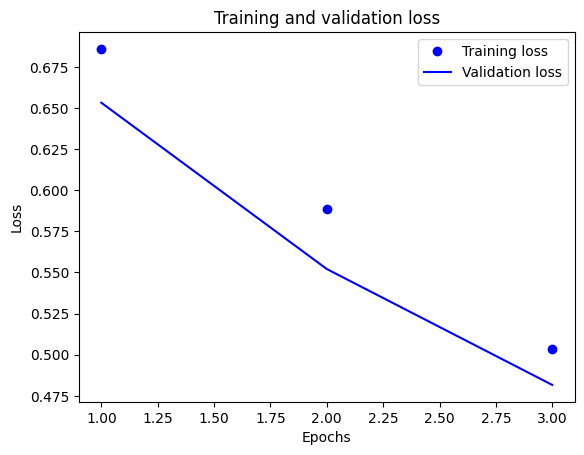

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# CNN - With Word2Vec Embedding

In [ ]:
mes = []
for i in df['text']:
  mes.append(i.split())

word2vec_model = Word2Vec(mes, vector_size=500, window=3, min_count=1, workers=16)
print(word2vec_model)

# since this is no longer supported, I copied and pasted the function from gensim
def gensim_to_keras_embedding(model, train_embeddings=False):
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer
embedding_layer = gensim_to_keras_embedding(word2vec_model)

Word2Vec<vocab=18774, vector_size=500, alpha=0.025>


In [ ]:
keras_model = Sequential()
keras_model.add(embedding_layer)
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(2))
keras_model.add(Activation('softmax'))
keras_model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')

In [ ]:
history = keras_model.fit(X_train, y_train, batch_size=16, epochs=3, validation_data=(X_test,y_test))

Epoch 1/3
387/387 [==============================] - 164s 419ms/step - loss: 0.3266 - acc: 0.8559 - val_loss: 0.1626 - val_acc: 0.9606
Epoch 2/3
387/387 [==============================] - 156s 401ms/step - loss: 0.1811 - acc: 0.9474 - val_loss: 0.1415 - val_acc: 0.9651
Epoch 3/3
387/387 [==============================] - 150s 387ms/step - loss: 0.1551 - acc: 0.9536 - val_loss: 0.1274 - val_acc: 0.9625


In [ ]:
pred = keras_model.predict(X_test)
print(X_test.shape)
pred_labels = np.where(pred >= 0.5, 1, 0)
print(classification_report(y_test, pred_labels))
print(f"accuracy - {accuracy_score(y_test,pred_labels)}")

49/49 [==============================] - 9s 190ms/step
(1547, 700)
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       780
           1       1.00      0.93      0.96       767

   micro avg       0.96      0.96      0.96      1547
   macro avg       0.97      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547
 samples avg       0.96      0.96      0.96      1547

accuracy - 0.962508080155139


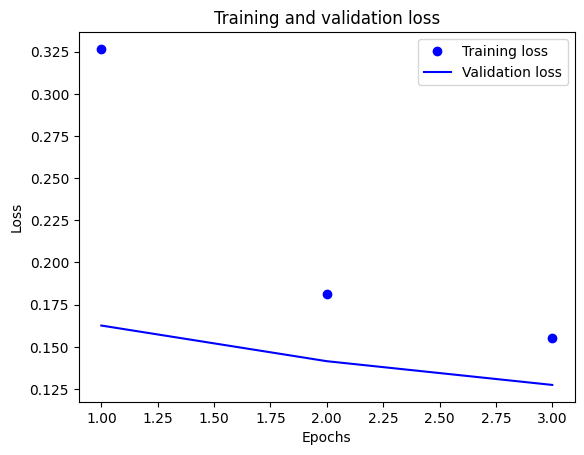

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Analysis

We can see from running the above script that we get very good results for training and testing.

Lets start by summarizing the accuracies of the four models that I created: 
* Sequential Model - 86%
* RNN - 97%
* CNN with minimal embedding - 94%
* CNN with Word2Vec embedding - 96%

We see that the simple sequential model performed the worst, but considering its 86%, relatively its performance is not that bad; however it can be improved as we see with the more complicated models.

The RNN model was simply made adding a simpleRNN layer to the model, as well as a embedded layer with the max vocab size and the padding size. We can see from the loss graph printed after the results the validation loss and training loss follow eachother well, thus indicating we have a well fit model.

The CNN model (with minimal embedding) was created by adding two Conv. layers and adjusting the rest of the model accordingly. This model is not as well fit as the previous, though both the validation and training loss still seem to follow one another.

The CNN model with the embedded layer first creates a Word2Vec model. This model is then transitioned into a layer and becomes the first layer on our new CNN model. This CNN models comprises of a repeated pattern of 2 Conv layers (which essentially act as filters), a 1D pool layer (which reduces the output dimensionality) and a dropout layer (which ensures the model is not too overfit). This creates a general and filtered model which is rather computationally intense, as we can see the runtime is much larger than all of the previous models.

 We can also see from the summary above that RNN performed the best in terms of accuracy. This can be expected an RNN typically performs better on sequential data (aka text) whereas CNN is better for spatial data (aka images). I wanted to see if I could get the performance of the CNN to match the RNN or even out perform it so I did a second CNN with a specialized embedded Word2Vec layer. 
 
 We can see from the results that we overall got very solid results with minute differences between the more complicated architectures.